In [1]:
import uproot
import tensorflow as tf
import zfit
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import hepstats

/opt/anaconda3/envs/m2_req/lib/python3.10/site-packages/zfit/__init__.py:59: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
data = zfit.Data.from_root("mu2e_caloSimu_crySpec674_HS.root", "specTree", ["spec", "ratio", "ntrig", "stim", "time", "tErg"]) #importing data from root file
cryspec = zfit.Space(['x'], limits=(2,8)) #observable range:: 1.5 limit is placed in fcl file
energy_unbinned = zfit.Data(data["spec"],obs=cryspec) #zfit.Data is used for unbinned data, obs has to be specified
print((energy_unbinned))

zfit.Data: Data obs=('x',) array=[[4.86858702]
 [4.91176796]
 [6.25674629]
 ...
 [6.27150917]
 [6.27150917]
 [6.27150917]]


In [3]:
print("Bin count calc: range / # of bins")
print("Bin count in order to keep y axis as events per 25keV is: ",(8-2)*1000/25)
print("Events per x keV once combined binning method is used: ", (8-1.5)*1000/212)

Bin count calc: range / # of bins
Bin count in order to keep y axis as events per 25keV is:  240.0
Events per x keV once combined binning method is used:  30.660377358490567


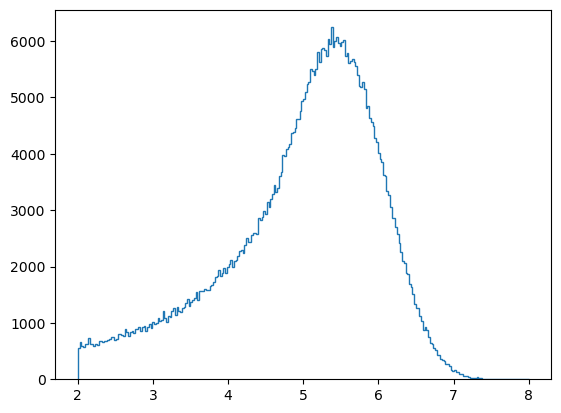

In [4]:
bin_count = 260 #trivially set depending on what we want the y axis to represent (x evts/kev)
energy_binned, bin_location, patches = plt.hist(energy_unbinned,bins=bin_count,histtype='step',range=(2,8)) #binning data and creating an x array of bin location

#### Parameters for 3 peaks

In [5]:
# defining functions for composed parameters
def frac_res_formula(params):
    return tf.pow((tf.pow(params["a"]/tf.pow((params["peak"]/1000),0.25),2)),0.5) + (params["b"])**2 + (params["c"]/params["peak"])**2

def multiply(params):
    return params["c"]*params["d"]

def subtract(params):
    return params["x"]-params["y"]

def EvnBG_formula(params):
    return params["total"]-params["full"]-params["first"]-params["second"]

In [6]:
ergElec = 0.511  #mass of electron in MeV 
fcbalpha = zfit.Parameter("fcbalpha", 2.5, 0.05, 20.0); # crystal ball constant alpha:: parameter where to switch from a gaussian to the powertail
fcbndeg = zfit.Parameter ("fcbndeg", 10, 0.25, 100); # crystal ball constant n::Exponent of the powertail
A = zfit.Parameter ("A constant", 0.01, 0.005, 1); # coefficient of E(GeV)^1/4
B = zfit.Parameter ("B constant", 0.5, 0.005, 1); # Constant term
C = 0.15 # Electronic noise in MeV
tot_evns = len(energy_unbinned) #total number of events

#Peaks
fullPeak = zfit.Parameter("full peak", 6, 4, 6.5); 
fstEsPeak = zfit.ComposedParameter("composed fst peak", subtract, params={"x":fullPeak,"y":ergElec})
scdEsPeak = zfit.ComposedParameter("composed scd peak", subtract, params={"x":fullPeak,"y":2*ergElec})

#fractional resolution
fullRes = zfit.ComposedParameter("Composed Full frac Res",frac_res_formula , params = {"a":A, "b":B,"c":C,"peak":fullPeak})
fstRes = zfit.ComposedParameter("Composed First frac Res",frac_res_formula , params = {"a":A, "b":B,"c":C,"peak":fstEsPeak})
scdRes = zfit.ComposedParameter("Composed Second frac Res",frac_res_formula , params = {"a":A, "b":B,"c":C,"peak":scdEsPeak})

#widths 
fullWidth = zfit.ComposedParameter("width of the full peak",multiply,params = {"c":fullPeak,"d":fullRes} )
fstWidth = zfit.ComposedParameter("width of the first peak",multiply,params = {"c":fstEsPeak,"d":fstRes} ) 
scdWidth = zfit.ComposedParameter("width of the second peak",multiply,params = {"c":scdEsPeak,"d":scdRes} )

#number of events in peak
EvnFull = zfit.Parameter("No. of Events in full peak", 500);
EvnFrst = zfit.Parameter("No. of Events in first escape peak", 500);
#EvnScd = zfit.ComposedParameter("No. of Events in second escape peak", EvnScd_func, params={"total":EvnSignal, "full":EvnFull,"first":EvnFrst});
EvnScd = zfit.Parameter("No. of Events in second escape peak", 500)
#EvnBG = zfit.ComposedParameter("Fraction of logistic background",subtract, params={"x":tot_evns,"y":Evnsignal})
EvnBG = zfit.ComposedParameter("Fraction of logistic background",EvnBG_formula, params={"total":tot_evns, "full":EvnFull,"first":EvnFrst,"second":EvnScd})

#logistic background parameters
comCnst = zfit.Parameter("comCnst", 4, 1, 20)
combeta = zfit.Parameter("combeta", 1, 0.01, 30)

print('----------------FRAC RES---------------')
print(fullRes)
print(fstRes)
print(scdRes)
print('-----------------WIDTHS---------------')
print(fullWidth)
print(fstWidth)
print(scdWidth)
print("------------------------")
print(scdEsPeak)
print(fstRes)
#print(EvnScd)
print(EvnScd)

----------------FRAC RES---------------
<zfit.ComposedParameter 'Composed Full frac Res' params=[('a', 'A constant'), ('b', 'B constant'), ('c', 'FIXED_autoparam_2'), ('peak', 'full peak')] value=0.2866>
<zfit.ComposedParameter 'Composed First frac Res' params=[('a', 'A constant'), ('b', 'B constant'), ('c', 'FIXED_autoparam_3'), ('peak', 'composed fst peak')] value=0.2875>
<zfit.ComposedParameter 'Composed Second frac Res' params=[('a', 'A constant'), ('b', 'B constant'), ('c', 'FIXED_autoparam_4'), ('peak', 'composed scd peak')] value=0.2886>
-----------------WIDTHS---------------
<zfit.ComposedParameter 'width of the full peak' params=[('c', 'full peak'), ('d', 'Composed Full frac Res')] value=1.719>
<zfit.ComposedParameter 'width of the first peak' params=[('c', 'composed fst peak'), ('d', 'Composed First frac Res')] value=1.578>
<zfit.ComposedParameter 'width of the second peak' params=[('c', 'composed scd peak'), ('d', 'Composed Second frac Res')] value=1.436>
-------------------

#### Logistic background PDF

In [7]:
class bckgrndPDF(zfit.pdf.ZPDF):
    _N_OBS = 1
    _PARAMS = ['comCnst3', 'combeta3']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = zfit.z.unstack_x(x)
        comCnst = self.params['comCnst3']
        combeta = self.params['combeta3']
        return 1.0/(1.0+tf.math.exp((x-comCnst)/combeta))

#### Range, Scale and Limits

In [8]:
lower, upper = cryspec.limits
x_range= cryspec.area()

#the pdfs below are normalised to =1 so must apply scaling factor 
scale = (len(energy_unbinned)/bin_count)*x_range

#TODO:: integrate from low bin edge to high bin edge instead of using bin center
bin_centers =  (bin_location[1:] + bin_location[:-1])/2

#### PDF Definition

In [9]:
fullErg = zfit.pdf.CrystalBall(obs=cryspec, mu=fullPeak, sigma=fullWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnFull)
#extended= frfull*frsignal does not work in the minimiser-- solution: make extended = # number pf events and when plotting pdf/total # events
firstErg = zfit.pdf.CrystalBall(obs=cryspec,mu=fstEsPeak,sigma=fstWidth,alpha=fcbalpha, n=fcbndeg, extended=EvnFrst)
secdErg = zfit.pdf.CrystalBall(obs=cryspec, mu=scdEsPeak, sigma=scdWidth, alpha=fcbalpha, n=fcbndeg, extended=EvnScd)
background = bckgrndPDF(obs=cryspec, comCnst3=comCnst,combeta3=combeta, extended = EvnBG)
signal_fit = zfit.pdf.SumPDF([fullErg,firstErg,secdErg],obs=cryspec,extended = True)
comb_fit = zfit.pdf.SumPDF([fullErg,firstErg,secdErg,background],obs=cryspec,extended = True)

#### Running PDF

In [10]:
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)
y_plot_signal = signal_fit.pdf(bin_centers,norm_range=cryspec)

Text(0.5, 0, 'E_reco [MeV]')

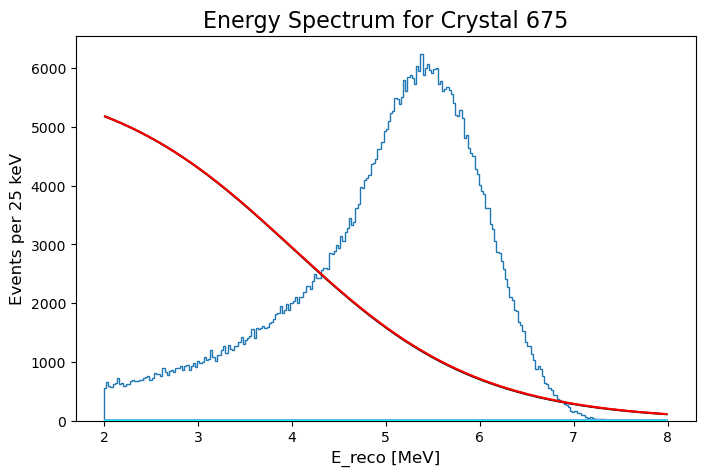

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.hist(energy_unbinned,bins=bin_count,histtype='step',range=(2,8))

plt.plot(bin_centers, y_plot_full*scale*EvnFull/len(energy_unbinned), color="olive", label='Full Peak CB')
plt.plot(bin_centers, y_plot_first*scale*EvnFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
plt.plot(bin_centers, y_plot_secd*scale*EvnScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
plt.plot(bin_centers, y_plot_logistic*scale*EvnBG/len(energy_unbinned), color="black", label='Full Peak CB')

#Combined Fit
plt.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')

# TODO:: create label box with info about chi sq
#plt.text(2,60,"\u03C7\u00B2/ndf:"+str(round((comb_chisq[0]/(len(energy_binned))),2)),fontsize=14)
#plt.text(2,50,"p_value: "+str(round(comb_chisq[1],10)),fontsize=14)

plt.title("Energy Spectrum for Crystal 675", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)

In [12]:
#check to see if sum of binned data is accurate length of unbinned data
print("Sum of binned data:",np.sum(energy_binned))
print("Length of unbinned data",len(energy_unbinned))
alldata_integral = scipy.integrate.trapz(y_plot_comb*scale)
print("Integral of crystal ball fit =",alldata_integral)

Sum of binned data: 539311.0
Length of unbinned data 539311
Integral of crystal ball fit = 536666.770421932


In [13]:

#constraint = zfit.core.constraint.SimpleConstraint(EvnFull+EvnFrst+EvnScd+EvnBG==len(energy_unbinned),params=[EvnFull,EvnFrst,EvnScd,EvnBG])

nll_comb = zfit.loss.ExtendedUnbinnedNLL(model=comb_fit, data=energy_unbinned)#, constraints=constraint)

minimizer = zfit.minimize.Minuit()

result = minimizer.minimize(nll_comb, params=[A,B,fcbalpha,fcbndeg,
                                                  fullPeak,EvnFull,
                                                  EvnFrst,EvnScd,
                                                  comCnst,combeta])
param_hesse = result.hesse()


print(result)
print('----------------FRAC RES---------------')
print(fullRes)
print(fstRes)
print(scdRes)
print('-----------------WIDTHS---------------')
print(fullWidth)
print(fstWidth)
print(scdWidth)
print('-----------------PEAKS----------------')
#print("Actual value of Frst Peak:",fstEsPeak)
#print("Actual value of Scnd Peak:",scdEsPeak)
#print("Expected value of Frst Peak:",fullPeak-0.511)
#print("Expected value of scnd Peak:",fullPeak-2*0.511)
print(fullPeak)
print(fstEsPeak)
print(scdEsPeak)
print('----------------# EVTS----------------')
print(EvnFull)
print(EvnFrst)
print(EvnScd)
print(EvnBG)
print('-----------------TOTALS--------------')
print("Total # of evts:",len(energy_unbinned))
print("Total Sum of all 4 fractions: ", EvnFull+EvnFrst+EvnScd+EvnBG)


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_11, Composed_autoparam_12, Composed_autoparam_13, Composed_autoparam_14]] data=[<zfit.Data: Data obs=('x',) shape=(539311, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.0088 │      -5848376.49 | -412670.8 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════╛

Parameters
name                                   value  (rounded)        hesse    at limit
-----------------------------------  ------------------  -----------  ----------
A constant                                    0.0215994  +/- 0.00025       False
B constant                     

In [14]:
# running pdfs again to load the minimized values of params
y_plot_full = fullErg.pdf(bin_centers,norm_range=cryspec)
y_plot_first = firstErg.pdf(bin_centers,norm_range=cryspec)
y_plot_secd = secdErg.pdf(bin_centers,norm_range=cryspec)
y_plot_comb = comb_fit.pdf(bin_centers,norm_range=cryspec)
y_plot_logistic = background.pdf(bin_centers,norm_range=cryspec)

### Chi square calculation

In [15]:
# combining binned data so that atleast 7 data points in each bin
combined_bins = []
current_bin = []

combined_edges = []
current_edge = []
left_edge = []
temp_bin = []
for (i,j) in zip(energy_binned,bin_location):
    current_bin.append(i)
    current_edge.append(j)

    if sum(current_bin)>=7:
        combined_bins.append(sum(current_bin[:]))
        combined_edges.append(current_edge.pop(0))
        current_edge.clear()
        current_bin.clear()
        
        
y_plot_comb_combedges = comb_fit.pdf(combined_edges,norm_range=cryspec)

chi_sq = np.sum(((y_plot_comb_combedges*scale)-(combined_bins))**2/(combined_bins))

ndf = len(combined_edges)-10-1

### P value calculation

In [16]:
p_value = scipy.stats.chi2.sf(chi_sq,ndf)
print(format(p_value,'0.2e'))

1.45e-25


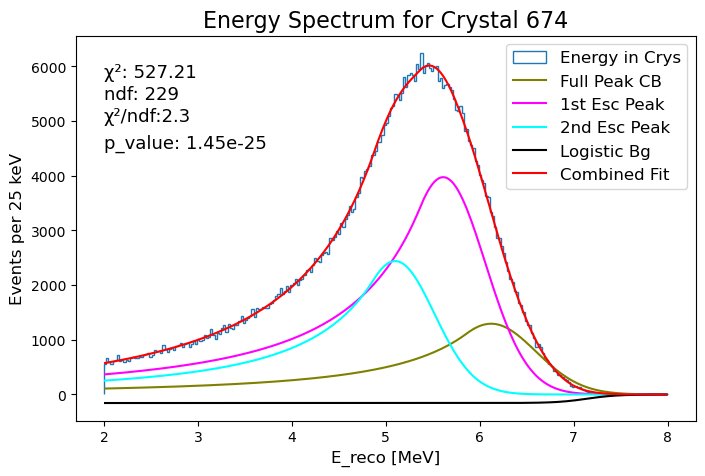

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
energy_binned, bin_location, patches = ax.hist(energy_unbinned,
                           bins=(bin_count),histtype='step',
                           range=(2,8), label= "Energy in Crys")

plt.plot(bin_centers, y_plot_full*scale*EvnFull/len(energy_unbinned), color="olive", label='Full Peak CB')
plt.plot(bin_centers, y_plot_first*scale*EvnFrst/len(energy_unbinned), color="magenta",label='1st Esc Peak')
plt.plot(bin_centers, y_plot_secd*scale*EvnScd/len(energy_unbinned), color="cyan",label='2nd Esc Peak')
#logistic background
plt.plot(bin_centers, y_plot_logistic*scale*EvnBG/len(energy_unbinned), color="black", label='Logistic Bg')

#Combined Fit
plt.plot(bin_centers, y_plot_comb*scale, color="red",label='Combined Fit')


# TODO:: create label box with info about chi sq, ndof, etc
plt.text(2,5000,"\u03C7\u00B2/ndf:"+str(round((chi_sq/ndf),2)),fontsize=13)
plt.text(2,5400,"ndf: "+str(round(ndf,2)),fontsize=13)
plt.text(2,5800,"\u03C7\u00B2: "+str(round(chi_sq,2)),fontsize=13)
plt.text(2,4500,"p_value: "+str(format(p_value,'0.2e')),fontsize=13)

plt.title("Energy Spectrum for Crystal 674", fontsize=16)
plt.ylabel('Events per 25 keV',fontsize=12)
plt.xlabel('E_reco [MeV]',fontsize=12)
leg = plt.legend(fontsize=12);